In [16]:
# Uses trench profiles for each Slab 2.0 slab, put together from Bird's plate boundaries segments.
# to get trench-perpendicular profiles and extract Slab 2.0 data along the profile

##### IMPORTANT NOTE #######
# This basically works except that there were issues with grdtrack that required work arounds:
# First when doing cross-profiles it is not resampling and the specfic profile spacing.
# The way around this would be to reasmple the trench every 10 km or so, then find all the cross profiles and then
# just extract the grid data for every nth profile depending on the users choice. 
# Second, even if the trenhc profiles are givin in 0/360 longitude, internally this gets switched to 180/-180
# which means it kind find  profiles in the -180 part of the grid. I found a way around this by running grdtrack
# once to get the profiles, correcting the longitudes and then rerunning to extract the data from the grid.
# This runs fairly quickly since it only extracts data for the resampled trench.

# Also one drawback to directly using grdtrack to get the cross tracks is that it does not output the profile
# azimuth, so there's not opportunity for the user to adjust this before doing the final extraction of  data.
# For this reason using the other approach with mapproject might be a better.
# The other difference is that this approach calculates the trench-perpendicular direction usign the original 10 km
# spacing. This means that regardless of spacing the profile at a given location always has the same orientation.
# Given local variations, it might be better to determine the azimuth from the resampled trench file.

# Magali Billen, 2022

# User chooses which Slab 2.0 slab
#   Calculates distance along the trench, resamples at regular spacing
#   Calculates forward azimuth at each point.
#   Calculates azimuth for perpedicular profile along great circle
#   Plots each of these profiles.
# User chooses which profile to use to extract data from Slab2.0
#   Makes final map of slab2.0 depth with trench and cross section profile
#   Writes out profile information x, y, distance, depth, dip.
#   Writes out json format data to define slab surface in WorldBuilder input file.

import pygmt
import numpy as np
import json
from os.path import exists as file_exists

In [17]:
# For plot read in topography for basemap and choose fonts
pygmt.config(FONT='10p,Times-Roman,black')
pygmt.config(FONT_LABEL='10p,Times-Roman,black')
pygmt.config(FONT_TITLE='10p,Times-Roman,black')
pygmt.config(MAP_TITLE_OFFSET='6.0p')

In [18]:

# Choose background data for maps: Only one of the next two options can by True.
# Add bathymetry to plots?
add_topo_grid = False  # This can take a while, so skip is not needed; useful for context in final figures
# Add seafloor age grid to plots? 
add_age_grid = True     # This can take a while, so skip is not needed; useful for context in final figures

# Add non-subducting plate boundaries to plots?
# All plots will include the plate boundary for the specified trench
add_nonsub_pb = False  #this can take a while so option to turn off; useful for context in final figures

if add_nonsub_pb == True:
    # Read in Bird's plate boundary data from a JSON format file
    dir = '/Users/billen/Box-Sync/Mybin/Data-Sets/tectonicplates-master/GeoJSON/'
    boundaries_json_file = dir + 'PB2002_boundaries.json'

    file_object = open(boundaries_json_file,'r')
    birddata = json.load(file_object)

# Directory where Slab2.0 data is kept
slab2dir ="/Users/billen/Box-Sync/Mybin/Data-Sets/Slab2Distribute_Mar2018/"\

# Define color-map file for Slab 2.0 data and create (using Fabio's scientific color maps)
cptfile ="slabdepth.cpt"
pygmt.makecpt(cmap="buda",series=(-700,0,100),output=cptfile)

In [19]:
# Slab 2.0 Slabs
# For each slab, list the unique subduction plate boundaries from Bird's data set.
# Name lists the plate boundary names from Bird's data set.
# Sort = 1, will sort combined coordinates into an ordered list by longitude
# Sort = 2, will sort combined coordinates into an ordered list by latitude
# Dip-Dir - indicates dominate dip direction of the slab: North, South, West or East
# (used for choosing profile direction and dip direction in WorldBuiler file)

slab2bird = {
    'alu' : {'Slab':'Aleutians','Name': ['NA/PA'], 'Sort': 1, 'Dip-Dir' : 'North', 'Flip': 0}, # Alaska, Central and West Aleutians
    'cal' : {'Slab':'Calabria','Name': ['EU/AF' ], 'Sort': 1, 'Dip-Dir' : 'North', 'Flip': 0}, # Calabria, 
    'cam' : {'Slab':'Central America','Name': ['NA/RI',' CO\\NA', 'CA/CO','CO\\PM'], 'Sort': 2, 'Dip-Dir' : 'East', 'Flip': 0}, # Central America, Mexico, El Salvador
    'car' : {'Slab':'Caribbean','Name': ['CA/SA'], 'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0}, # Caribbean, Lesser Antilles, Puerto Rico
    'cas' : {'Slab':'Cascadia','Name': ['JF\\NA'], 'Sort': 2, 'Dip-Dir' : 'East', 'Flip': 0}, # Cascadia
    'cot' : {'Slab':'Cotabato','Name': ['' ], 'Sort': 0, 'Dip-Dir' : 'East', 'Flip': 0}, # Cotabato, near philippines
    'hal' : {'Slab':'Halmahera','Name': ['' ],  'Sort': 0, 'Dip-Dir' : 'East', 'Flip': 0}, # Halmahera
    'hel' : {'Slab':'Helleni','Name': ['AS/AF','AT/AF'], 'Sort': 1, 'Dip-Dir' : 'North', 'Flip': 0}, # Hellenic
    'him' : {'Slab':'Himalaya','Name': ['' ],  'Sort': 0, 'Dip-Dir' : 'North', 'Flip': 0}, # Himalaya
    'hin' : {'Slab':'Hindu Kush','Name': ['' ],  'Sort': 0, 'Dip-Dir' : 'North', 'Flip': 0}, # Hindu Kush
    'izu' : {'Slab':'Izu-Bonin Marianas','Name': ['PS/PA','MA/PA'],  'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0},# Izu-Bonin, Izu, N and S. Marianas
    'ker' : {'Slab':'Tonga-Kermadec','Name': ['KE/PA','TO/PA'],  'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0},# Tonga, Kermadec, New Zealand
    'kur' : {'Slab':'Kuriles-Japan','Name': ['OK/PA','PA\\OK'], 'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0}, # Kuriles, Kamchatka and Japan
    'mak' : {'Slab':'Makran','Name': ['' ],  'Sort': 0, 'Dip-Dir' : 'North', 'Flip': 0},# Makran
    'man' : {'Slab':'Manilla','Name': ['PS/SU'], 'Sort': 2, 'Dip-Dir' : 'East', 'Flip': 0}, # Manilla
    'mue' : {'Slab':'Muertos','Name': ['' ], 'Sort': 0, 'Dip-Dir' : 'East', 'Flip': 0}, # Muertos
    'pam' : {'Slab':'Pamir','Name': ['' ], 'Sort': 0, 'Dip-Dir' : 'North', 'Flip': 0}, # Pamir
    'phi' : {'Slab':'Philippines','Name': ['PS\\SU'], 'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0}, # North, Central, South Philippines
    'png' : {'Slab':'New Guinea','Name': ['CL\\WL', 'NB\\WL'], 'Sort': 1, 'Dip-Dir' : 'South', 'Flip': 0}, # New Guinea
    'puy' : {'Slab':'Puysegur','Name': ['PA/AU', 'AU\\PA'], 'Sort': 2, 'Dip-Dir' : 'East', 'Flip': 0}, # Puysegur
    'ryu' : {'Slab':'Ryuku Nankai','Name': ['ON/PS', 'AM/PS'], 'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0}, # Central and South Ryuku, Nankai
    'sam' : {'Slab':'South America','Name': ['AN\\SA','NZ\\SA','NZ\\AP','NZ\\ND','ND/NZ'],  'Sort': 2, 'Dip-Dir' : 'East', 'Flip': 0},# Colombia, Ecuador-Peru, Peru, Chile
    'sco' : {'Slab':'Scotia','Name': ['SW/SA' ],  'Sort': 2, 'Dip-Dir' : 'West', 'Flip': 0},# Scotia
    'sol' : {'Slab':'Solomons','Name': ['SB/SS','NB/SS','PA/SS', 'PA/WL', 'PA/AU'], 'Sort': 1, 'Dip-Dir' : 'North', 'Flip': 0}, # Solomons, Bougainville, New Britain
    'sul' : {'Slab':'Sulawesi','Name': ['MS/SU'], 'Sort': 1, 'Dip-Dir' : 'South', 'Flip': 0}, # Sulawesi
    'sum' : {'Slab':'Java Sumatra','Name': ['SU/AU','BU/AU','BU/IN','IN\\BU'], 'Sort': 2, 'Dip-Dir' : 'North', 'Flip': 1}, # Sumatra, Andaman Islands, Java, Timo, Maluku
    'van' : {'Slab':'Vanuatu','Name': ['NH/AU'],  'Sort': 1, 'Dip-Dir' : 'East', 'Flip': 0}, # Vanuatu    
}

# loc = list(slab2bird.keys())


In [20]:
# User chooses a slab and profile spacing
print('Choose a slab location:')
for i in range(len(slab2bird)):
    print(list(slab2bird.keys())[i], list(slab2bird.items())[i][1]['Slab'])

# These combined trench_coords.xy files were made from the original Bird plate boundary 
# segements and then combined into trench profiles for each slab 2.0 location
# See: bird_plate_boundaries_2_slab2_0.ipynb
file_found = False
while file_found == False:
    loc1 = input('Enter the 3-letter code for the slab location: ')

    trenchfile = loc1 + '_trench_coords.xy'

    if file_exists(trenchfile) == False:
        print('File: ', trenchfile,' not found. Choose a different slab.')
    else:
        print('File: ', trenchfile,' found')
        file_found = True

# TO DO ADD: need option for output to be converted to kilometers for cartesian models.
# Maybe this goes at the very end, since need locations in degrees for creating slab segments.

#prof_spacing = int(input('Enter profile spacing MUST be divisible by 10 (eg., 50, 210) in km: '))
#print('Profile spacing is ', prof_spacing, ' km')

print('Spacing between profiles in degrees (1 degree is about 111 km)')
prof_spacing = float(input('Enter profile spacing (MUST be divisible by 0.1 deg): '))
print('Profile spacing is ', prof_spacing, ' degrees')

Choose a slab location:
alu Aleutians
cal Calabria
cam Central America
car Caribbean
cas Cascadia
cot Cotabato
hal Halmahera
hel Helleni
him Himalaya
hin Hindu Kush
izu Izu-Bonin Marianas
ker Tonga-Kermadec
kur Kuriles-Japan
mak Makran
man Manilla
mue Muertos
pam Pamir
phi Philippines
png New Guinea
puy Puysegur
ryu Ryuku Nankai
sam South America
sco Scotia
sol Solomons
sul Sulawesi
sum Java Sumatra
van Vanuatu
Enter the 3-letter code for the slab location: cas
File:  cas_trench_coords.xy  found
Spacing between profiles in degrees (1 degree is about 111 km)
Enter profile spacing (MUST be divisible by 0.1 deg): 0.5
Profile spacing is  0.5  degrees


In [21]:
# Find Distance and azimuth along trench, 
# Note these  GMT functions do not yet exists in the PyGMT package, so I am used the
# session.call_module approach in order to be able to used this functions.
# this is clunky because the output is written to a file and then needs to be read back in again.

# Step 1: use map project to get the distance along the trench profile
# -Gd (or -Gk) gives cumulative distance, along profile in degrees (or kilometers).
data_list = [ ];
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"{trenchfile} -Gd ->{tmpfile.name}")
        data_str = tmpfile.read().strip()
        data_lines = data_str.split('\n')
        for i in range(len(data_lines)):
            data_list.extend([float(value) for value in data_lines[i].split(' ')])

tmpdata = np.array(data_list)

# n is the number of profiles along the trench at the desied spacing.
n = int(tmpdata.size/3)  # has 3 columns, lon, lat and distance
data0 = tmpdata.reshape(n,3)
tmp0 = 'tempfile0'
np.savetxt(tmp0,data0)

# Step 2: Resample the track at user defined spacing "prof_spacing" (in degrees)
# -Ar+d: equidistant and remove duplicates; -N2 distance is in column 2 (0, 1, 2); -Fl: linear interpolation
data_list = [ ];
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile1:
        session.call_module("sample1d", f"{tmp0} -Ar+d -T{prof_spacing}d -N2 -Fl ->{tmpfile1.name}")
        data_str = tmpfile1.read().strip()
        #print(data_str)
        data_lines = data_str.split('\n')
        for i in range(len(data_lines)):
            data_list.extend([float(value) for value in data_lines[i].split(' ')])
tmpdata = np.array(data_list)

n = int(tmpdata.size/3)  # has 3 columns, lon, lat, distances
data1 = tmpdata.reshape(n,3)
p = np.where(data1[:,0]<0)  # wrap around -180/180 to 0 to 360
data1[p,0] = 360 + data1[p,0] 
tmp1 = 'tempfile1'
np.savetxt(tmp1,data1)

# Step 3: Calculate the azimuth of trench between points along profile in the forward direction
# -Ao gives azimuth as orientations  (+90 to -90) instead of 0 to 360.
data_list = [ ];
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile2:
        session.call_module("mapproject", f"{tmp1} -Ao ->{tmpfile2.name}")
        data_str = tmpfile2.read().strip()
        #print(data_str)
        data_lines = data_str.split('\n')
        for i in range(len(data_lines)):
            data_list.extend([float(value) for value in data_lines[i].split(' ')])
tmpdata = np.array(data_list)

n = int(tmpdata.size/4)  # now has 4 columns, lon, lat, dist, azim
trench_data = tmpdata.reshape(n,4)
trench_data[0,3] = trench_data[1,3] # replace NaN azimuth for first location with the next value

# Step 4: change azimuths to be perpendicular to profile in the dip direction
# so we can create profiles perpendicular to the trench
# For plotting profile numbers
lontext = trench_data[:,0]
lattext = trench_data[:,1] 
if slab2bird[loc1]['Dip-Dir'] == 'South':
    p = np.where(trench_data[:,3] > 0)
    trench_data[p,3] = trench_data[p,3] - 180.0
    trench_data[:,3] = trench_data[:,3] - 90
    lattext = lattext + 1.0
elif slab2bird[loc1]['Dip-Dir'] == 'North':
    p = np.where(data[:,3] > 0)
    trench_data[p,3] = trench_data[p,3] - 180.0
    trench_data[:,3] = trench_data[:,3] + 90
    lattext = lattext - 1.0
if slab2bird[loc1]['Dip-Dir'] == 'West':
    trench_data[:,3] = trench_data[:,3] - 90.0
    lontext = lontext + 1.0 
elif slab2bird[loc1]['Dip-Dir'] == 'East':
    trench_data[:,3] = trench_data[:,3] + 90.0
    lontext = lontext - 1.0 


Region:  225.0/247.0/33.0/56.0
Cascadia (0.5 km)
Adding coastlines and this trench...
Plotting 26 profiles


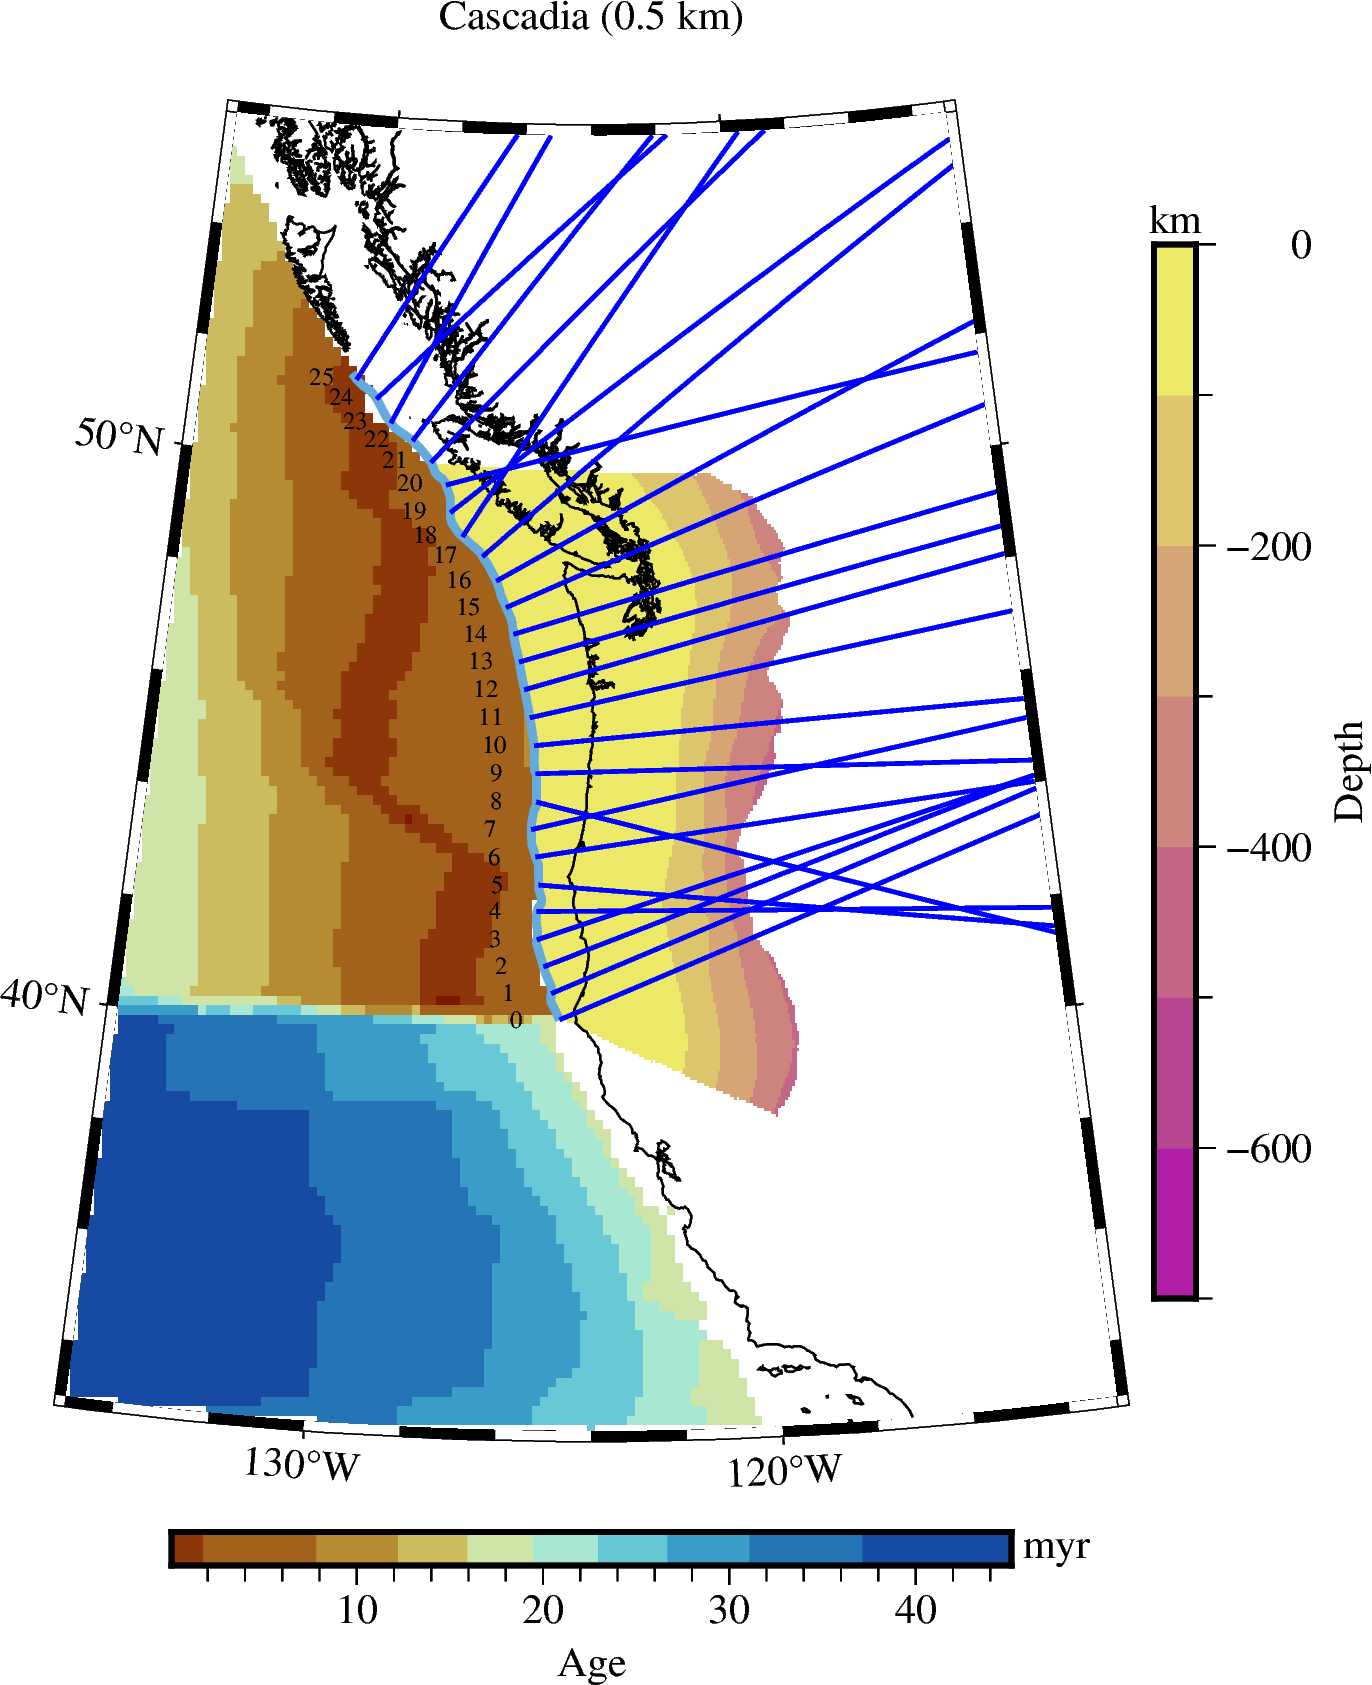

In [22]:
# Make the figure showing the locations of the trench-perpendicular profiles

# Get Regional Map dimensions
# Use the slab 2.0 data to set the size of the regional plot
grdfile = slab2dir + loc1 + '_slab2_dep.grd'
data_list = pygmt.grdinfo(grdfile,per_column=True).split()
region_data = np.array([float(value) for value in data_list])

west = region_data[0] - 2.0
east = region_data[1] + 2.0
south = region_data[2] - 2.0
north = region_data[3] + 2.0

region1 = str(west) + '/' + str(east) + '/' + str(south) + '/' + str(north) 
print('Region: ', region1)

# Get center position and two latitude locations to define regional projection
clon = np.floor(region_data[0:2].mean())
clat = np.floor(region_data[2:4].mean())
lat1 = np.floor(0.5*(north - clat) + clat )
lat2 = np.floor(clat - 0.5*(clat - south) )

mapwidth = 3.5 # inches, sets size of figure on page
proj1 = 'B' + str(clon) + '/' + str(clat) + '/' + str(lat1) + '/' + str(lat2) + '/' + str(mapwidth) + 'i'

# Start figure
fig = pygmt.Figure()
title = slab2bird[loc1]['Slab'] + ' (' + str(prof_spacing)  + ' km'+ ')'
print(title)
fig.basemap(region=region1, projection=proj1, frame=["af", f'WSne+t"{title}"'])

# Add base-map data if desired.
if add_topo_grid == True:
    topogrid = pygmt.datasets.load_earth_relief(region=region1,resolution="10m",registration="gridline")
    fig.grdimage(grid=topogrid,cmap="gray")
# Or use the age-grid as a basemap layer
elif add_age_grid == True:
    agegrid = pygmt.datasets.load_earth_age(region=region1,resolution="10m",registration="gridline")
    # Use this method so the colorscale is equalized to the area of the plot. 
    colormap1 = pygmt.grd2cpt(grid=agegrid,cmap='roma')
    fig.grdimage(grid=agegrid,cmap=colormap1)
    fig.colorbar(cmap=colormap1,position="JBC+h", box=False, frame=["x+lAge", "y+lmyr"])

# Add the slab 2.0 data
depth_grdfile = slab2dir + loc1 + '_slab2_dep.grd'
fig.grdimage(grid=depth_grdfile,nan_transparent=True,cmap=cptfile)
# add a colorbar for depth    
fig.colorbar(cmap=cptfile,position="JMR", box=False, frame=["x+lDepth", "y+lkm"])

# Add on the non-subduction plate boundaries, if desired
if add_nonsub_pb == True:    
    print('Plotting non-subduction plate boundaries and coast lines...')
    for i in range(len(birddata["features"])):
        coords = np.array(birddata["features"][i]["geometry"]["coordinates"])
        fig.plot(x=coords[:,0],y=coords[:,1], pen="1p,white")

# Overlay the coastlines
print('Adding coastlines and this trench...')
fig.coast(shorelines="1/0.5p,black",resolution="i")
# Add on this trench
data = np.loadtxt(trenchfile)
fig.plot(x=data[:,0],y=data[:,1],pen='2p,100/170/220')

pen_prof = "1p,blue"
if add_topo_grid == True:
    font_profnum = "6p,Times-Roman,white"
else:
    font_profnum = "6p,Times-Roman,black"

# Plot all the trench-perpendicular Profiles with numbers.
prof_length = 15 # deg, 
prof_ds = 0.1 # deg, sampling along cross profile

print('Plotting', n, 'profiles')
for i in range(n):
    prof_points = pygmt.project(center=[trench_data[i,0], trench_data[i,1]], azimuth=trench_data[i,3], 
                                length=[0, prof_length], generate=prof_ds, unit=False)

    fig.plot(x=prof_points.r, y=prof_points.s, pen="1p,blue")  
    fig.text(text=str(i), x=lontext[i],y=lattext[i], font=font_profnum) 

fig.show()

Choose profile number to use for WorldBuilder Input: 3
Profile information (start-lon, start-lat, azimuth):  234.703508569 41.7260463039 70.97252786199999
Do you want to adjust the profile of the slab (0-no, 1-yes?)1
Enter new azimuth: 80


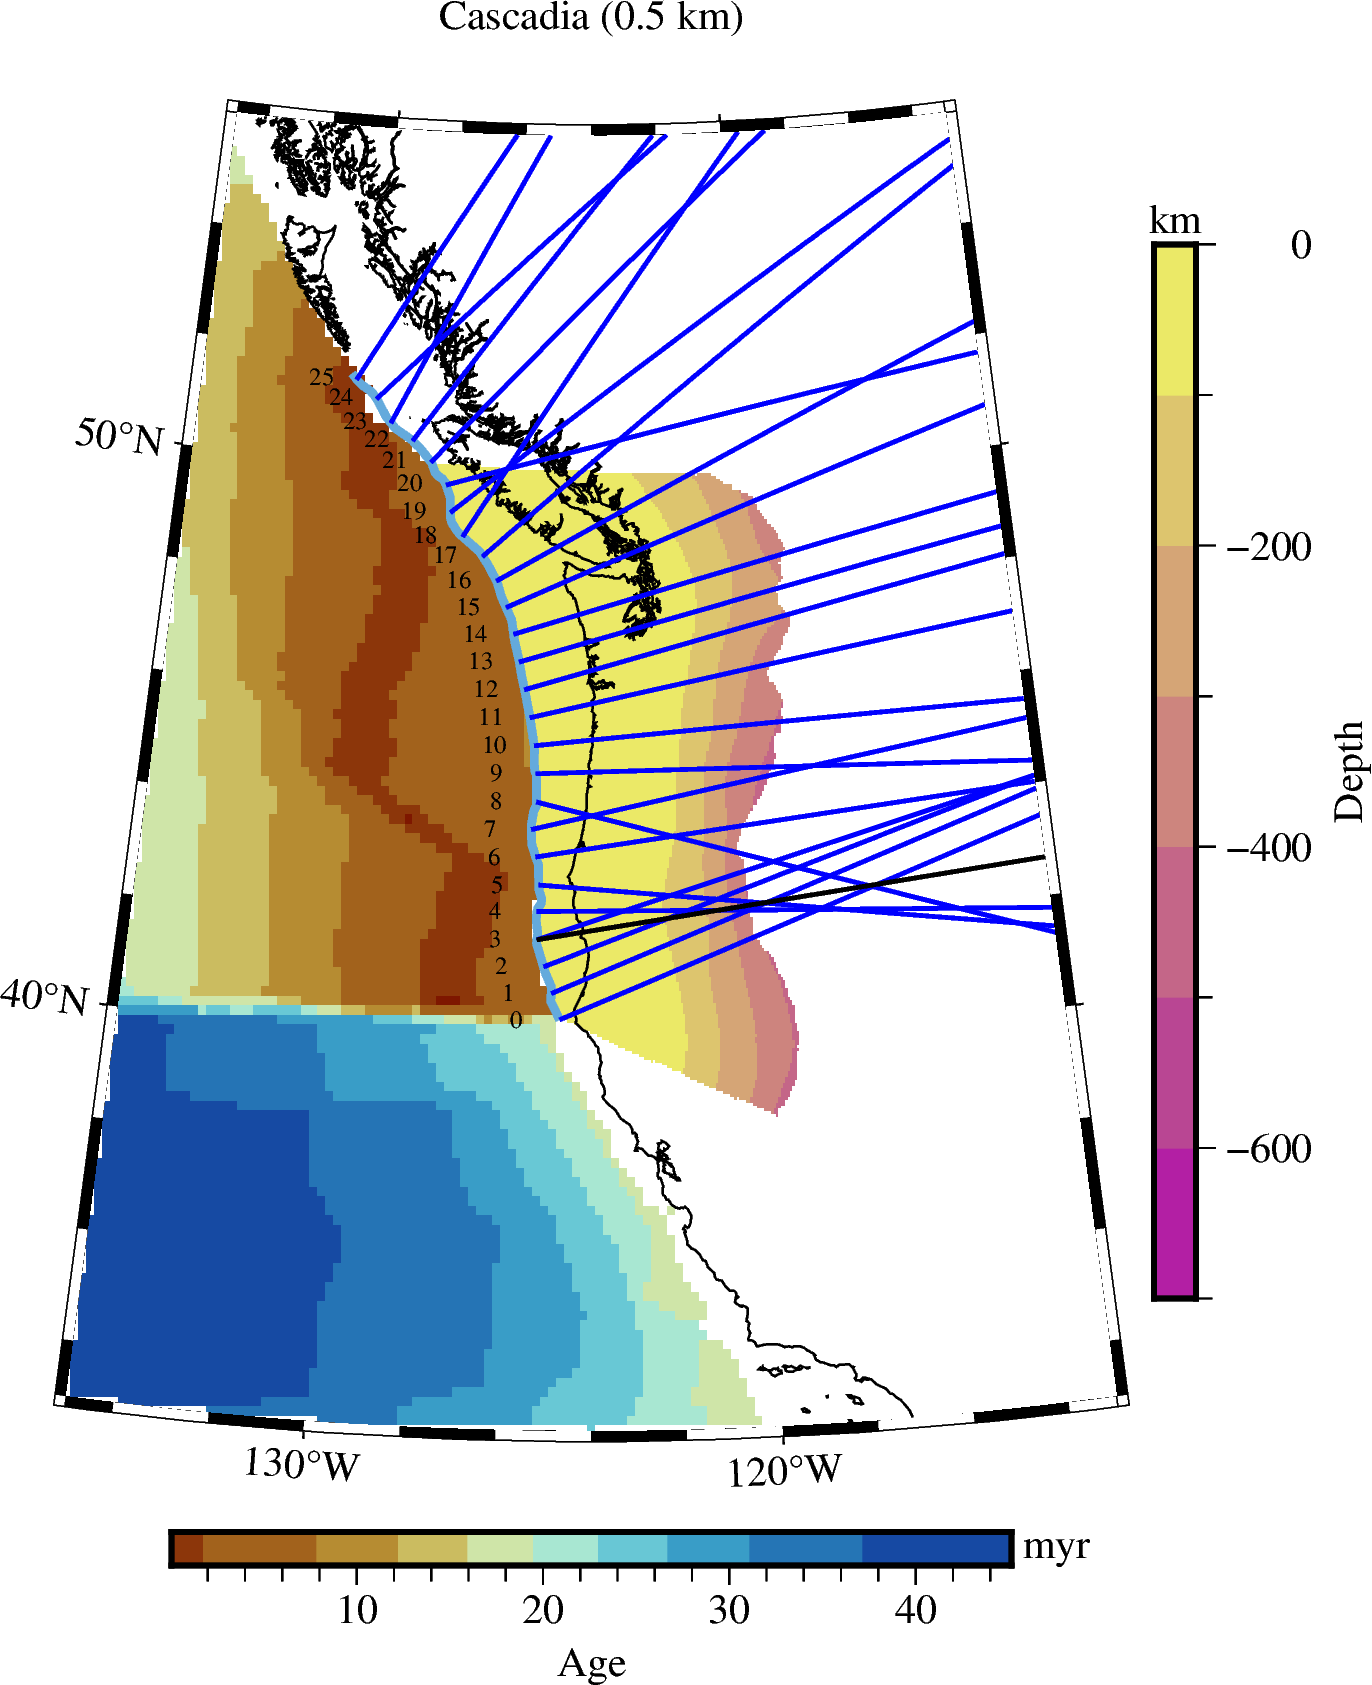

Adjust more (0-no, 1-yes?)0
Using azimuth =  80


grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


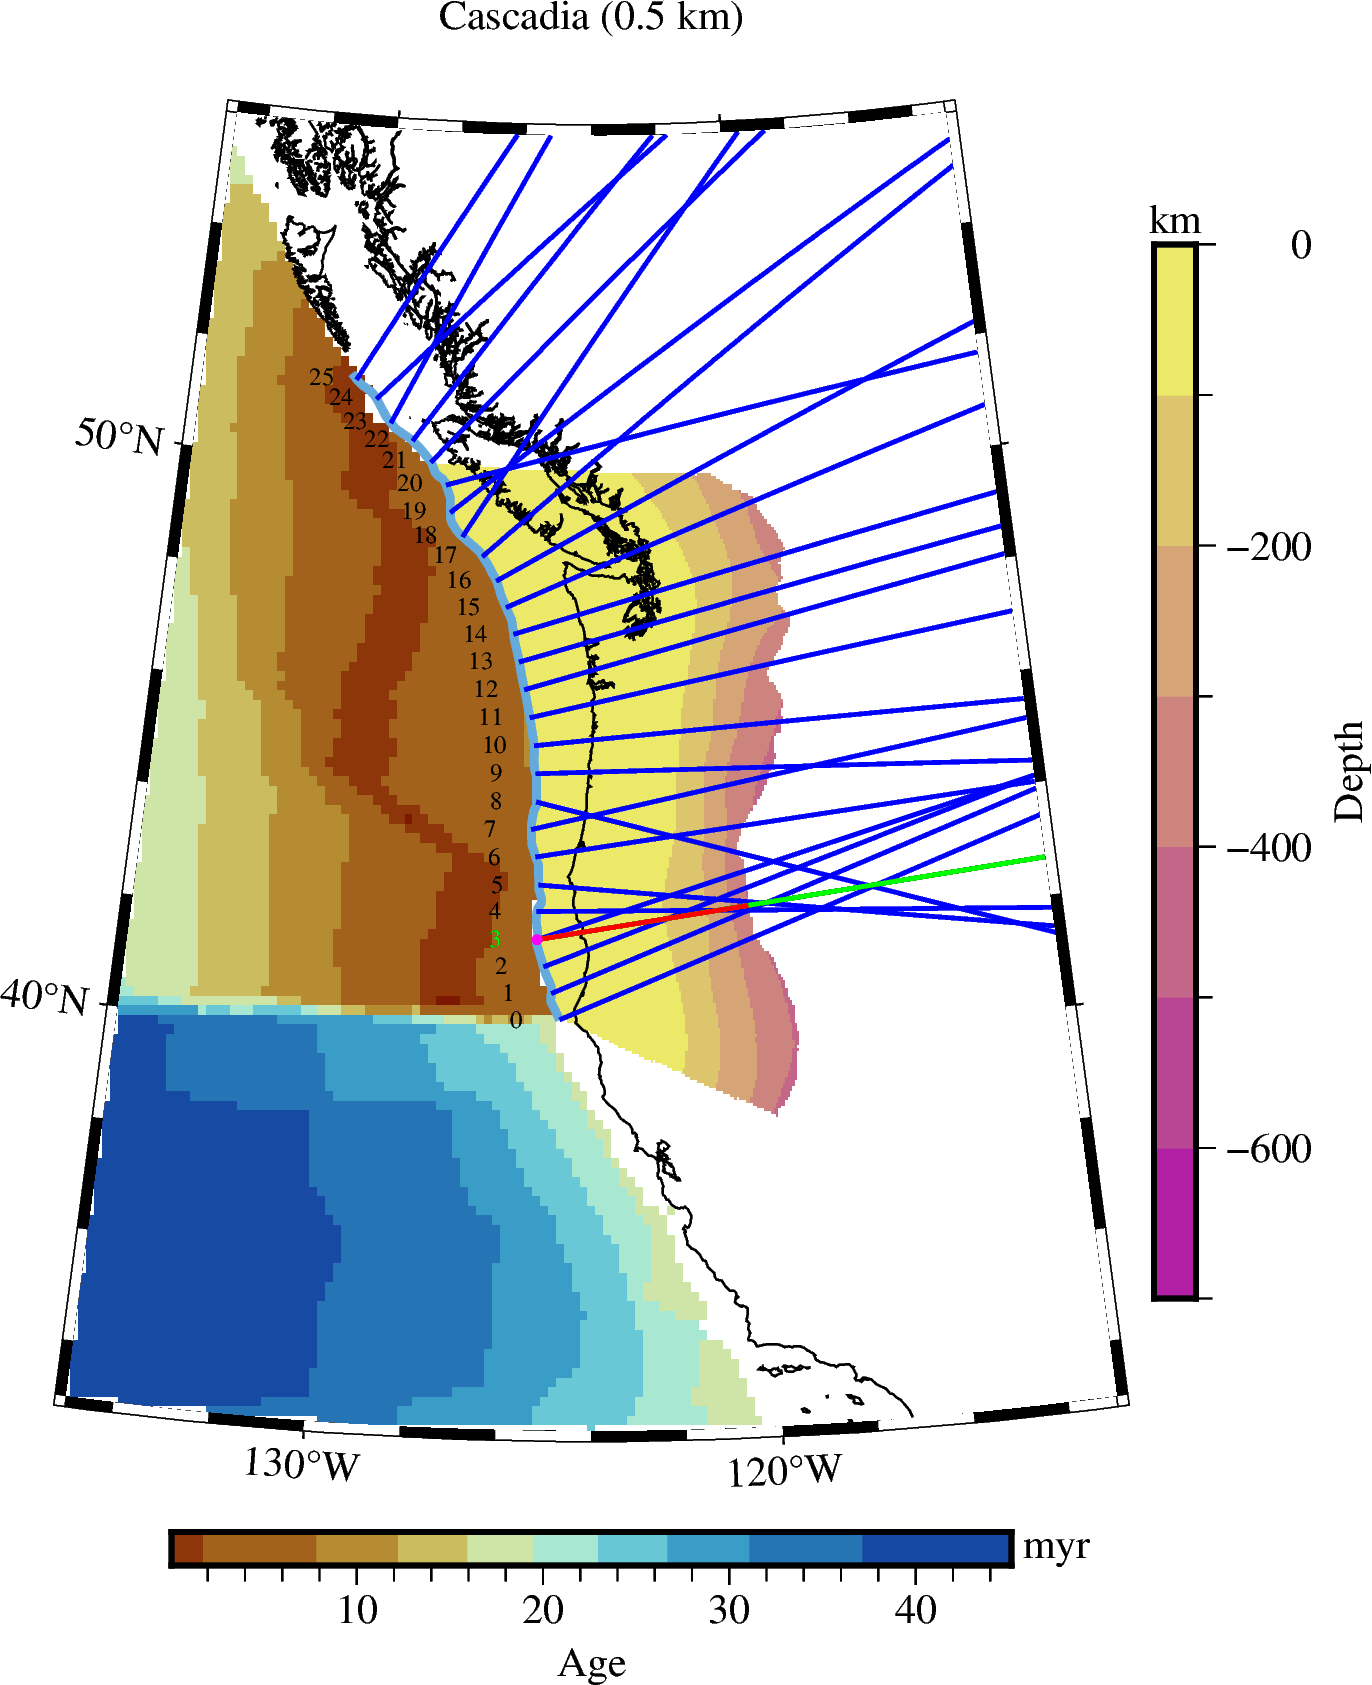

In [23]:
# Next step is to choose which profile to use for WorldBuilder Input

wbnum = int(input('Choose profile number to use for WorldBuilder Input: '))

az0 = trench_data[wbnum,3]
print('Profile information (start-lon, start-lat, azimuth): ', trench_data[wbnum,0], trench_data[wbnum,1], az0)
az_adjust = bool(int(input('Do you want to adjust the profile of the slab (0-no, 1-yes?)')))
while az_adjust == True:
    az0 = input('Enter new azimuth: ')
    prof_points = pygmt.project(center=[trench_data[wbnum,0], trench_data[wbnum,1]], azimuth=az0, 
                                length=[0, prof_length], generate=prof_ds, unit=False)
    fig.plot(x=prof_points.r, y=prof_points.s, pen="1p,black")  
    fig.text(text=str(az0), x=prof_points.r[len(prof_points.r)-1], y=prof_points.s[len(prof_points.r)-1], font=font_profnum) 
    fig.show()
    az_adjust = bool(int(input('Adjust more (0-no, 1-yes?)')))

print('Using azimuth = ', az0)
prof_points = pygmt.project(center=[trench_data[wbnum,0], trench_data[wbnum,1]], 
                            azimuth=az0, length=[0, prof_length], generate=prof_ds, unit=False)

# need to switch longitude to 0 to 360 to work with slab 2.0 grid
prof_array = prof_points.to_numpy()
p = np.where(prof_array[:,0]< 0)
prof_array[p,0] = 360.0 + prof_array[p,0] 

# prof_ppoints on the subducting plate side to get age and bathymetry
# add 180 to the azimuth; length=5 deg with 0.1 degree sampling.
#prof_points_sp = pygmt.project(center=[data[wbnum,0], data[wbnum,1]], azimuth=data[wbnum,3]+180, length=[0, 5], generate=0.1, unit=True)

# Slab2.0 data files 
depth_grdfile = slab2dir + loc1 + '_slab2_dep.grd'
dip_grdfile = slab2dir + loc1 + '_slab2_dip.grd'

# Now use cross tracks as sample points to get depth and dip along each profile
prof_depth =  pygmt.grdtrack(points=prof_array, grid=depth_grdfile,no_skip=True)
prof_dip =  pygmt.grdtrack(points=prof_array, grid=dip_grdfile,no_skip=True)
# Convert to numpy arrays
prof_data1 = prof_depth.to_numpy()
prof_data2 = prof_dip.to_numpy()

# Combine into one array and reshape so its easier to extract information for a single profile
prof_tmp = np.append(prof_data1, np.transpose([prof_data2[:,3]]), axis=1)

p = np.squeeze(np.where(~np.isnan(prof_tmp[:,3])))
wbprof = np.squeeze(prof_tmp[p,:])

lonstart = lontext[wbnum]
latstart = lattext[wbnum]

# lon, lat, depth and dip at the trench
# Used for entering the trench location in the worldBuilder file
lon_trench, lat_trench = trench_data[wbnum,0:2]

# Show the chosen profile and the trench location on the figure
fig.plot(x=prof_tmp[:,0],y=prof_tmp[:,1],pen='1p,green')
fig.plot(x=wbprof[:,0],y=wbprof[:,1],pen='1p,red')
fig.plot(x=wbprof[0,0],y=wbprof[0,1],pen='1p,magenta',style='c0.05c')
font_profnum = "6p,Times-Roman,green"
fig.text(text=str(wbnum), x=lonstart,y=latstart, font=font_profnum) 
fig.show()
pngfile = outfile = slab2bird[loc1]['Slab'] + '_' + str(prof_spacing) + 'k_' + str(wbnum) + '.png'
#fig.savefig(pngfile)

In [24]:
# In the numerical model the top of the model domain is not at sea-level,
# but is instead some mean depth. A better reference to use is the median
# depth of subducting plate seaward of the trench. 

# This is then used to shift the depths of the slab relative to sea-level
# to be depths relative to the median depth. 
# Use profile in opposite direction over shorter distance to determine 
# median bathymetric depth seaward of the trench.
az4bath = az0 + 180.0
prof_length_bath = 5.0 # degrees, about 200 km)
prof_points_bath = pygmt.project(center=[trench_data[wbnum,0], trench_data[wbnum,1]], 
                            azimuth=az4bath, length=[0, prof_length_bath], generate=prof_ds, unit=False)
prof_bath_array = prof_points_bath.to_numpy()

bath_prof_list =  pygmt.grdtrack(points=prof_bath_array, grid='@earth_relief_10m_g')
bath_prof_array = bath_prof_list.to_numpy() # lon, lat, bath

bath_median = np.floor(np.abs(np.median(bath_prof_array[:,3])))
print('Median bathymetric depth seaward of the trench: ', bath_median, ' m')

TypeError: can only concatenate str (not "float") to str

In [10]:
# Calculate the segment lengths for WorldBuildder

# For each segment, calculate arc length 
km2m = 1000 # m/km
Re = 6371.137 # km
d2r = np.pi/180

# Need to make these one longer than the profile in order to get a point
# at the trench with a dist = 0, depth = 0 and dip = 0
p,q = wbprof.shape

d = np.zeros((p+1,))  # distance in degrees
depth = np.zeros((p+1,))
dip = np.zeros((p+1,))

# if there are p+1 points, there at p segments in between
C = np.zeros((p,))
theta = np.zeros((p,))
R = np.zeros((p,))
S = np.zeros((p,))

# Format of wbprof: lon, lat, distance (deg), - depth (km), dip (deg)
d[1:p+1] = np.abs(wbprof[:,2])    # distance in degrees along profile

# need positive depths and shift relative to median bethymetry.
# this puts trench at depth of 0 km.
km2m = 1000  # m per km
print('Adjusting depths by:', bath_median/km2m  , ' km')
depth[1:p+1] = np.abs(wbprof[:,3]) - bath_median/km2m   
dip[1:p+1] = wbprof[:,4]

# Get distance from 1st point in profile to the trench at depth = 0
# this only depths assuming a straight line for this one segment.
dy = depth[p-1]-depth[p]
surf_dist = np.abs(np.arcsin(dy/Re)/d2r)  # arc distance

# adjust distances so 0 is at the trench (depth = 0)
print('Adjusting distances by:', surf_dist, 'degrees')
d[1:p+1] = d[1:p+1] + surf_dist

# a. Calculate radius at point i (Re) and point i+1 (Re-depth)
r = Re - depth  # km
		
# b. Convert to cartesian coordinates
# x(i) = r(i)*sin(d_angle)
# y(i) = r(i)*cos(d_angle)

x = r*np.cos(d*d2r)  # km
y = r*np.sin(d*d2r)  # km

#for debugging
#print('i, depth, dist, dip, radius, x, y')
#for i in range(p+1):
#    print("%4i,%9.2f %9.2f %9.2f %9.2f %9.2f %9.2f" % (i, depth[i], d[i], dip[i], r[i], x[i], y[i]))

# c. Calculate the chord length from point i to point i+1 
#    C = sqrt( (x(i+1)- x(i))^2 + (y(i+1)- y(i))^2  )

# this will be a like a loop
n = range(0,p)
m = range(1,p+1)
C[n] = np.sqrt( (x[m] - x[n])**2 + (y[m] - y[n])**2)  # km

# d. Calculate the angle between point i and i+1
#    theta = dip(i+1) - dip(i)  in radians

theta[n] = np.abs((dip[m] - dip[n]))*d2r

# e. Calculate radius of circle connecting both points
# R  = C/(2*sin(theta/2))
R[n] = C[n]/(2*np.sin(0.5*theta[n]))  # km

# f. Calculate arc length from point i to point i+1
# S = R*theta  (in km since dpeth and Re were in km)
S[n] = R[n]*theta[n]   # km

# For debugging
#print("i, C, theta, R, S, dip1, dip2")
#for i in range(p):
#	print("%4i %9.2f %9.2f %9.2f %9.2f %9.2f %9.2f" % (i,C[i],theta[i],R[i],S[i],dip[i],dip[i+1]))


Adjusting depths by: 5.651  km
Adjusting distances by: 0.24245628732662236 degrees


In [11]:
# Last step: write out the WorldBuilder Input File

# Write-out slab segment information Worldbuilder Segment format
#"segments":[
#             {"length":450e3, "thickness":[100e3], "angle":[20]},
#             {"length":450e3, "thickness":[100e3], "angle":[40]}
#           ],
thickness = 200  # km  slab thickness

# Output file for slab segments in json format.
str_wbnum = str(wbnum).zfill(3)
outfile = loc1 + '_' + str(prof_spacing) + 'd_p' + str_wbnum + '_az' + f"{az0:.3f}" + '_wb_slab_segments.json'
print(outfile)

#outfile = slab2bird[loc1]['Slab'] + '_' + str(prof_spacing) + 'k_' + str(wbnum)
f = open(outfile,'w')
line = ' { "segments":[ \n'
f.write(line)

for i in range(p-1):
	arclen = "{:.3f}".format(S[i]) + 'e03'   # in meters
	thk = "{:.1f}".format(thickness) + 'e03' # in meteres
	dipn = "{:.3f}".format(dip[i+1])
	dipm = "{:.3f}".format(dip[i])

	line = ' {"length":' + arclen + ', "thickness":[' + thk + '], "angle":[' + dipm + ',' + dipn + ']}, \n'
	f.write(line)
	
arclen = "{:.3f}".format(S[p-1]) + 'e03'   # in meters
thk = "{:.1f}".format(thickness) + 'e03' # in meteres
dipn = "{:.3f}".format(dip[p])
dipm = "{:.3f}".format(dip[p-1])

line = ' {"length":' + arclen + ', "thickness":[' + thk + '], "angle":[' + dipm + ',' + dipn + ']} \n'
f.write(line)
line = ' ] } \n'
f.write(line)	
f.close()

izu_0.4d_p085_az-91.349_wb_slab_segments.json


In [12]:
# Write out other parts of subducting slab input 
# Get seafloor age at the trench location
age_trench_list =  pygmt.grdtrack(points=np.array([[lon_trench, lat_trench]]), grid='@earth_age_10m_g')
age_trench_array = age_trench_list.to_numpy() # lon, lat, age

age_trench = np.round(age_trench_array[0,2]*10)/10  # round to nearest 0.1 myr
print('Age at trench: ', age_trench, ' myr')

Age at trench:  140.8  myr


In [15]:
# Check that file was run correctly.
file_object = open('izu_0.4d_p085_az-91.349_wb_slab_segments.json','r')
wbdict = json.load(file_object)

print(wbdict)

{'segments': [{'length': 27239.0, 'thickness': [200000.0], 'angle': [0.0, 4.55]}, {'length': 11153.0, 'thickness': [200000.0], 'angle': [4.55, 5.173]}, {'length': 11161.0, 'thickness': [200000.0], 'angle': [5.173, 5.779]}, {'length': 11171.0, 'thickness': [200000.0], 'angle': [5.779, 6.419]}, {'length': 11184.0, 'thickness': [200000.0], 'angle': [6.419, 7.188]}, {'length': 11204.0, 'thickness': [200000.0], 'angle': [7.188, 8.247]}, {'length': 11238.0, 'thickness': [200000.0], 'angle': [8.247, 9.8]}, {'length': 11300.0, 'thickness': [200000.0], 'angle': [9.8, 12.04]}, {'length': 11410.0, 'thickness': [200000.0], 'angle': [12.04, 15.058]}, {'length': 11590.0, 'thickness': [200000.0], 'angle': [15.058, 18.763]}, {'length': 11859.0, 'thickness': [200000.0], 'angle': [18.763, 22.842]}, {'length': 12214.0, 'thickness': [200000.0], 'angle': [22.842, 26.843]}, {'length': 12618.0, 'thickness': [200000.0], 'angle': [26.843, 30.321]}, {'length': 13010.0, 'thickness': [200000.0], 'angle': [30.321,

Next steps.... read in this json file from the script that writes the full worldbuilder file and then run it!